In [104]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.io import decode_image

train_image_path = val_image_path = "./dataset/fairface-img-margin025-trainval/"
train_label_path = "./dataset/fairface_label_train.csv"
val_label_path = "./dataset/fairface_label_val.csv"


In [105]:
classes = ['East Asian', 'Indian', 'Black', 'White', 'Middle Eastern', 'Latino_Hispanic', 'Southeast Asian']
class_count = 7

class FairFaceDataset(Dataset):
    def __init__(self, image_path, label_path, transform=None, normalize=False):
        self.image_path = image_path
        self.file_path = pd.read_csv(label_path)["file"]
        self.labels_raw = pd.read_csv(label_path)["race"]

        cat = pd.Categorical(self.labels_raw, categories = classes, ordered = True)
        cat = pd.Series(cat.codes)
        # One-hot encode the labels
        self.labels = torch.nn.functional.one_hot(torch.tensor(cat).long(), num_classes=class_count)
        # print(self.labels.shape)
        # print(self.labels)

        norm = None
        if(normalize):
            norm = torchvision.transforms.Compose([
                    torchvision.transforms.ConvertImageDtype(torch.float),
                    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #imagenet parameters
                ])
        else:
            norm = torchvision.transforms.ConvertImageDtype(torch.float)
        if(transform is None):
            transform = torchvision.transforms.Resize((112, 112))
        self.transform = transform
        self.norm = norm
        self.augs = [
            None,
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomVerticalFlip(),
            torchvision.transforms.RandomRotation(degrees=179),
            torchvision.transforms.RandomPerspective(),
            torchvision.transforms.RandomAffine(degrees=0, translate=(0.2,0.2))
        ]

    def __len__(self):
        return len(self.labels)*len(self.augs)

    def __getitem__(self, idx):
        img_idx = idx // len(self.augs)
        aug_idx = idx % len(self.augs)

        img_file = os.path.join(self.image_path, self.file_path.iloc[img_idx])
        image = decode_image(img_file, mode = "RGB")
        # print(image.shape)
        # print(image)

        if aug_idx != 0:
            augmentation = self.augs[aug_idx]
            image = augmentation(image)
            print(f"Applied augmentation: {augmentation}")

        label_str = self.labels_raw.iloc[img_idx]
        label = self.labels[img_idx]
        downsample = self.transform(image)
        downsample = self.norm(downsample)
        image = self.norm(image)
        print("Debug: After norm:", downsample.shape, downsample.dtype)
        print("Debug: Before transform:", image.shape, image.dtype)
        if(downsample.shape[1] != 112 or downsample.shape[2] != 112):
            downsample = torchvision.transforms.Resize((112,112))(downsample)
        # if not float tensor:
        if downsample.dtype != torch.float:
            downsample = torchvision.transforms.ConvertImageDtype(torch.float)(downsample)
        print("Debug: After transform:", downsample.shape, downsample.dtype)

        return downsample, image, label, label_str


In [106]:
train_dataset = FairFaceDataset(train_image_path, train_label_path)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = FairFaceDataset(val_image_path, val_label_path)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Debug: After norm: torch.Size([3, 112, 112]) torch.float32
Debug: Before transform: torch.Size([3, 224, 224]) torch.float32
Debug: After transform: torch.Size([3, 112, 112]) torch.float32


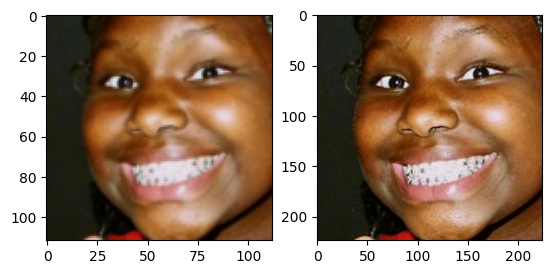

Applied augmentation: RandomHorizontalFlip(p=0.5)
Debug: After norm: torch.Size([3, 112, 112]) torch.float32
Debug: Before transform: torch.Size([3, 224, 224]) torch.float32
Debug: After transform: torch.Size([3, 112, 112]) torch.float32


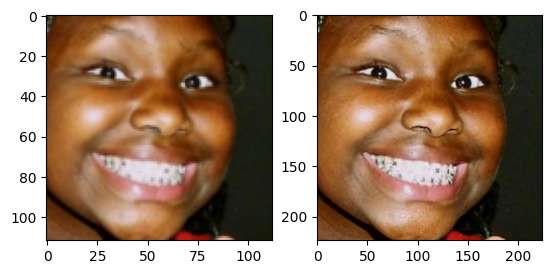

Applied augmentation: RandomVerticalFlip(p=0.5)
Debug: After norm: torch.Size([3, 112, 112]) torch.float32
Debug: Before transform: torch.Size([3, 224, 224]) torch.float32
Debug: After transform: torch.Size([3, 112, 112]) torch.float32


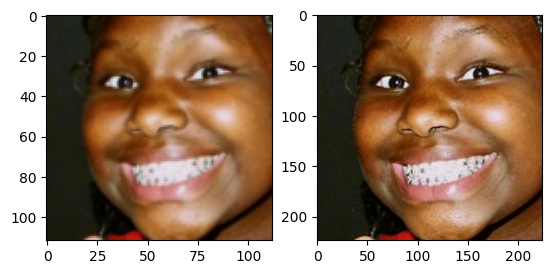

Applied augmentation: RandomRotation(degrees=[-179.0, 179.0], interpolation=nearest, expand=False, fill=0)
Debug: After norm: torch.Size([3, 112, 112]) torch.float32
Debug: Before transform: torch.Size([3, 224, 224]) torch.float32
Debug: After transform: torch.Size([3, 112, 112]) torch.float32


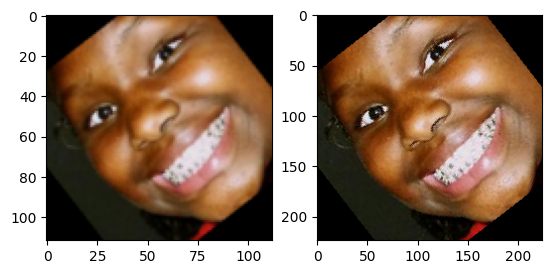

Applied augmentation: RandomPerspective(p=0.5)
Debug: After norm: torch.Size([3, 112, 112]) torch.float32
Debug: Before transform: torch.Size([3, 224, 224]) torch.float32
Debug: After transform: torch.Size([3, 112, 112]) torch.float32


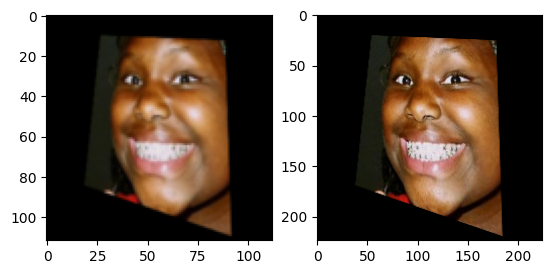

Applied augmentation: RandomAffine(degrees=[0.0, 0.0], translate=(0.2, 0.2))
Debug: After norm: torch.Size([3, 112, 112]) torch.float32
Debug: Before transform: torch.Size([3, 224, 224]) torch.float32
Debug: After transform: torch.Size([3, 112, 112]) torch.float32


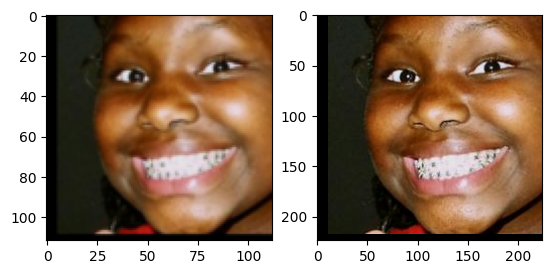

In [107]:
def view(img1, img2):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img1.permute(1, 2, 0))
    axes[0].axis('on')
    axes[1].imshow(img2.permute(1, 2, 0))
    axes[1].axis('on')
    plt.show()
    
# print(len(train_dataset), len(val_dataset))
test = 128
for test in range(6*test, 6*(test+1)):
    tests = train_dataset[test]
    view(tests[0], tests[1])